In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS9_K265_DinhVietHa/LDS9_K265_DinhVietHa_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K265_DinhVietHa/LDS9_K265_DinhVietHa_Cuoi_ky


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [ ]:
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .appName("Corona") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "10g") \
  .config("spark.driver.memory", "10g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","10g")\
  .getOrCreate()
spark

#Load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("./Du lieu cung cap/cbc-news-coronavirus-articles-march-26/news.csv", header=0, index_col=0)

In [ ]:
data.head()

,authors,title,publish_date,description,text,url
0,['Cbc News'],Coronavirus a 'wake-up call' for Canada's pres...,2020-03-27 08:00:00,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,https://www.cbc.ca/news/health/covid-19-drug-s...
1,['Cbc News'],Yukon gov't names 2 possible sources of corona...,2020-03-27 01:45:00,The Yukon government has identified two places...,The Yukon government has identified two places...,https://www.cbc.ca/news/canada/north/yukon-cor...
2,['The Associated Press'],U.S. Senate passes $2T coronavirus relief package,2020-03-26 05:13:00,The Senate has passed an unparalleled $2.2 tri...,The Senate late Wednesday passed an unparallel...,https://www.cbc.ca/news/world/senate-coronavir...
3,['Cbc News'],Coronavirus: The latest in drug treatment and ...,2020-03-27 00:36:00,Scientists around the world are racing to find...,Scientists around the world are racing to find...,https://www.cbc.ca/news/health/coronavirus-tre...
4,['Cbc News'],The latest on the coronavirus outbreak for Mar...,2020-03-26 20:57:00,The latest on the coronavirus outbreak from CB...,Trudeau says rules of Quarantine Act will ...,https://www.cbc.ca/news/the-latest-on-the-coro...


In [ ]:
df_news = spark.createDataFrame(data)

In [ ]:
df_news.show()

+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|             authors|               title|       publish_date|         description|                text|                 url|
+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|        ['Cbc News']|Coronavirus a 'wa...|2020-03-27 08:00:00|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|
|        ['Cbc News']|Yukon gov't names...|2020-03-27 01:45:00|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|
|['The Associated ...|U.S. Senate passe...|2020-03-26 05:13:00|The Senate has pa...|The Senate late W...|https://www.cbc.c...|
|        ['Cbc News']|Coronavirus: The ...|2020-03-27 00:36:00|Scientists around...|Scientists around...|https://www.cbc.c...|
|        ['Cbc News']|The latest on the...|2020-03-26 20:57:00|The latest on the...|    Trudeau says ...|https:

In [ ]:
df_news.printSchema()

root
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



In [ ]:
df_news.count()

3566

In [ ]:
df_news.select("authors").distinct().show(10,truncate=50)

+--------------------------------------------------+
|                                           authors|
+--------------------------------------------------+
|['Prince Edward Island', 'Wayne Thibodeau Is A ...|
|['Jason Warick Is A Reporter With Cbc Saskatoon.']|
|['Investigative Journalist', "Timothy Sawa Work...|
|['Brian Higgins Shoots Video', 'Reports News On...|
|['Dr. Vivek Goel Was The Founding Head Of Publi...|
|['Cbc News', "Terry Roberts Is A Journalist Wit...|
|                          ['The Associated Press']|
|['Senior Writer', "Adam Miller Is Senior Digita...|
|['Janine Legal Is A Freelance Writer', 'A Grass...|
|['Cbc Staff', 'Alvin Yu Splits His Time Along T...|
+--------------------------------------------------+
only showing top 10 rows



In [ ]:
df_news.select("authors").distinct().count()

261

In [ ]:
from pyspark.sql.functions import col, udf, to_timestamp, year
from pyspark.sql.functions import isnan, when, count
from pyspark.sql.functions import lit, concat

In [ ]:
from pyspark.sql.types import DateType, StringType

In [ ]:
df_news = df_news.withColumn("publish_date",to_timestamp("publish_date"))

In [ ]:
df_news.printSchema()

root
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



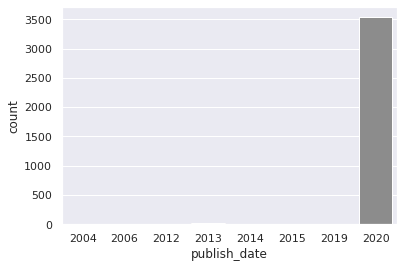

In [ ]:
sns.set(style="darkgrid")
sns.countplot(data=data, x=data['publish_date'].astype('datetime64').dt.year)
plt.show()

All articles were published in 2020, the year when Covid-19 exploded.

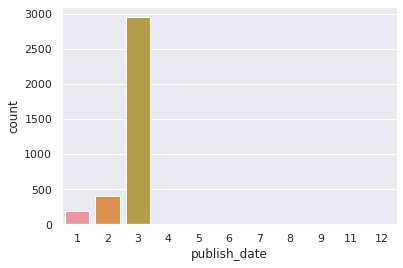

In [ ]:
sns.set(style="darkgrid")
sns.countplot(data=data, x=data['publish_date'].astype('datetime64').dt.month)
plt.show()

The published month are January, February and March, where March had the highest publishments.

# Data preprocessing

## Text cleaning

Combine column title, description and text into one column

In [ ]:
df_text = df_news.select("title","description","text")

In [ ]:
df_text = df_text.withColumn("text_new", concat(col("title"), lit(" "), col("description"), lit(" "), col("text")).alias("text"))

In [ ]:
df_text.show(5)

+--------------------+--------------------+--------------------+--------------------+
|               title|         description|                text|            text_new|
+--------------------+--------------------+--------------------+--------------------+
|Coronavirus a 'wa...|Canadian pharmaci...|Canadian pharmaci...|Coronavirus a 'wa...|
|Yukon gov't names...|The Yukon governm...|The Yukon governm...|Yukon gov't names...|
|U.S. Senate passe...|The Senate has pa...|The Senate late W...|U.S. Senate passe...|
|Coronavirus: The ...|Scientists around...|Scientists around...|Coronavirus: The ...|
|The latest on the...|The latest on the...|    Trudeau says ...|The latest on the...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df_text = df_text.drop('title','description','text')

In [ ]:
df_text.show(5)

+--------------------+
|            text_new|
+--------------------+
|Coronavirus a 'wa...|
|Yukon gov't names...|
|U.S. Senate passe...|
|Coronavirus: The ...|
|The latest on the...|
+--------------------+
only showing top 5 rows



#### Clean the data: 
* lowercase the words
* remove special character, links, squared brackets, number in words, punctuation
* remove the word coronavirus as it is the overall topic of the articles

In [ ]:
import re
import string

In [ ]:
from pyspark.sql.functions import trim

In [ ]:
def clean_text(text):
  
  text = str(text).lower()
  text = re.sub('[^\w\s]','',text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub('coronavirus','',text)
  
  return text

In [ ]:
udfclean = udf(clean_text, StringType())

In [ ]:
df_clean = df_text.withColumn("text_clean", udfclean(df_text.text_new))

In [ ]:
# trim the whitespace
df_clean = df_clean.withColumn("text_clean", trim(col("text_clean")))

In [ ]:
df_clean.show(10, truncate=50)

+--------------------------------------------------+--------------------------------------------------+
|                                          text_new|                                        text_clean|
+--------------------------------------------------+--------------------------------------------------+
|Coronavirus a 'wake-up call' for Canada's presc...|a wakeup call for canadas prescription drug sup...|
|Yukon gov't names 2 possible sources of coronav...|yukon govt names  possible sources of  exposure...|
|U.S. Senate passes $2T coronavirus relief packa...|us senate passes   relief package the senate ha...|
|Coronavirus: The latest in drug treatment and v...|the latest in drug treatment and vaccine develo...|
|The latest on the coronavirus outbreak for Marc...|the latest on the  outbreak for march  the late...|
|'Worse' pandemic on horizon unless world deals ...|worse pandemic on horizon unless world deals wi...|
|What you need to know about COVID-19 in Ottawa ...|what you nee

In [ ]:
df_clean.count()

3566

In [ ]:
df_clean = df_clean.select("text_clean")

## Feature transformation



In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

Add the stop word corona into StopWordRemover as these articles are all about corona virus.

In [ ]:
stop_words= ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]

In [ ]:
tokenizer = Tokenizer(inputCol="text_clean", outputCol="token_text")
stopremove = StopWordsRemover(inputCol="token_text", outputCol="stop_tokens",stopWords=stop_words)
count_vec = CountVectorizer(inputCol="stop_tokens", outputCol="c_vec")
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
# class_to_num = StringIndexer(inputCol="Rating", outputCol="label")

In [ ]:
clean_up = VectorAssembler(inputCols=["tf_idf"], outputCol="features")

## Pipeline

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
data_prep_pipe = Pipeline(stages = [tokenizer,
                                   stopremove,count_vec,idf,clean_up])

In [ ]:
cleaner = data_prep_pipe.fit(df_clean)

In [ ]:
clean_data = cleaner.transform(df_clean)

In [ ]:
clean_data.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          text_clean|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|a wakeup call for...|[a, wakeup, call,...|[wakeup, call, ca...|(67087,[0,1,2,4,6...|(67087,[0,1,2,4,6...|(67087,[0,1,2,4,6...|
|yukon govt names ...|[yukon, govt, nam...|[yukon, govt, nam...|(67087,[0,1,2,3,7...|(67087,[0,1,2,3,7...|(67087,[0,1,2,3,7...|
|us senate passes ...|[us, senate, pass...|[senate, passes, ...|(67087,[0,1,2,3,1...|(67087,[0,1,2,3,1...|(67087,[0,1,2,3,1...|
|the latest in dru...|[the, latest, in,...|[latest, drug, tr...|(67087,[0,1,4,6,7...|(67087,[0,1,4,6,7...|(67087,[0,1,4,6,7...|
|the latest on the...|[the, latest, on,...|[latest, , outbre...|(67087,[0,1,2,3,4...|(67087,[0,1,2,3,4..

## Train the Model and evaluate


### select k with minimum WSSSE: k between 2-10

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# Trains a k-means model
k_list = []
wssse_list = []
for k in range(2,11):
    kmeans = KMeans(featuresCol='features',k=k)
    #kmeans = KMeans(featuresCol='text_clean', k=k)
    model = kmeans.fit(clean_data)
    wssse = model.computeCost(clean_data)
    k_list.append(k)
    wssse_list.append(wssse)
    print("With k=",k,"Set Sum of Squared Errors = " + str(wssse))

With k= 2 Set Sum of Squared Errors = 35158620.5668962
With k= 3 Set Sum of Squared Errors = 35037440.35439786
With k= 4 Set Sum of Squared Errors = 35010141.47974619
With k= 5 Set Sum of Squared Errors = 34692756.165311165
With k= 6 Set Sum of Squared Errors = 34917401.10848006
With k= 7 Set Sum of Squared Errors = 34616038.345277354
With k= 8 Set Sum of Squared Errors = 34430682.147194006
With k= 9 Set Sum of Squared Errors = 34557950.628328495
With k= 10 Set Sum of Squared Errors = 34565145.728891745


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

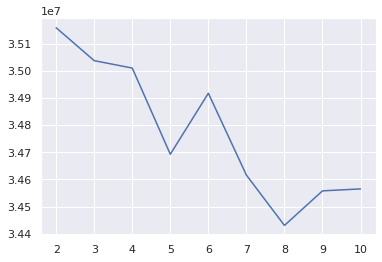

In [ ]:
plt.plot(k_list, wssse_list)
plt.show()

Based on the graph above, k=5 or k=8 are some good choices. Here I choose k=5 .

#### select k=5

In [ ]:
# Train a k-means model
kmeans = KMeans(featuresCol='features',k=5)
model = kmeans.fit(clean_data)

# Evaluate clustering by computing Within Set Sum of Squared Errors
wssse = model.computeCost(clean_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 34692756.165311165


In [ ]:
# Show the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.0117311  1.03452592 0.77588131 ... 0.0022314  0.0022314  0.0022314 ]
[0.0110301  0.28902666 0.34199648 ... 0.         0.         0.        ]
[0.01011523 0.65492211 0.43347274 ... 0.         0.         0.        ]
[0.0585473  4.63373421 2.86929251 ... 0.         0.         0.        ]
[0.00841279 1.04049598 1.31912928 ... 0.         0.         0.        ]


In [ ]:
# Predict
predictions = model.transform(clean_data)

In [ ]:
predictions.select("prediction").show(5)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



In [ ]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         2|  141|
|         3|   59|
|         0| 3355|
|         1|    9|
|         4|    2|
+----------+-----+



# Visualize the centers with WordCloud

In [ ]:
data_prep_pipe.getStages()

[Tokenizer_b97ce914dbbb,
 StopWordsRemover_eebafde5b5da,
 CountVectorizer_253bd6074a4d,
 IDF_2f5fd119e324,
 VectorAssembler_45da030374d5]

In [ ]:
vectorizerModel = cleaner.stages[2]
vocabList = vectorizerModel.vocabulary
vocabList[:10]

['',
 'health',
 'people',
 'cases',
 'public',
 'canada',
 'virus',
 'government',
 'outbreak',
 'spread']

In [ ]:
centers_arr = np.array(centers, dtype="float32")

In [ ]:
print("Top terms per cluster:")
order_centroids = centers_arr.argsort()[:, ::-1]
terms = vocabList
for i in range(5):
     print("Cluster %d:" % i, end='')
     for ind in order_centroids[i, :10]:
         print(' %s' % terms[ind], end='')
         print()

Top terms per cluster:
Cluster 0: china
 cases
 canadians
 government
 health
 canada
 workers
 city
 bc
 virus
Cluster 1: leadership
 party
 candidates
 otoole
 conservative
 race
 mackay
 deadline
 peterson
 candidate
Cluster 2: students
 school
 classes
 schools
 university
 teachers
 student
 education
 parents
 online
Cluster 3: cases
 iran
 reported
 happening
 china
 south
 korea
 deaths
 italy
 confirmed
Cluster 4: sterzer
 village
 flats
 canal
 testing
 they likely
 the kootenays says
 hes frustrated
 henry
 bc


In [ ]:
g = globals()

for i in range(5):
    varname = 'cluster{}'.format(i)
    g[varname] = []
    for ind in order_centroids[i, :]:
         g[varname].append(terms[ind])

In [ ]:
for cluster in [cluster0, cluster1, cluster2, cluster3, cluster4]:
    print(" ".join(cluster[:15]))
    print("\n")

china cases canadians government health canada workers city bc virus care province cruise public emergency


leadership party candidates otoole conservative race mackay deadline peterson candidate campaign karahalios sloan ballot lewis


students school classes schools university teachers student education parents online learning district college exams courses


cases iran reported happening china south korea deaths italy confirmed ship countries read japan hamilton


sterzer village flats canal testing they likely the kootenays says hes frustrated henry bc suspected honestly mayor bonnie frustrated




In [ ]:
from wordcloud import WordCloud

In [ ]:
cluster0_string=(" ").join(cluster0)
cluster1_string=(" ").join(cluster1)
cluster2_string=(" ").join(cluster2)
cluster3_string=(" ").join(cluster3)
cluster4_string=(" ").join(cluster4)

In [ ]:
wordcloud0 = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 14).generate(cluster0_string) 

In [ ]:
wordcloud1 = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 14).generate(cluster1_string)  

In [ ]:
wordcloud2 = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 14).generate(cluster2_string)  

In [ ]:
wordcloud3 = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 14).generate(cluster3_string)  

In [ ]:
wordcloud4 = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 14, stopwords=stop_words).generate(cluster4_string)  

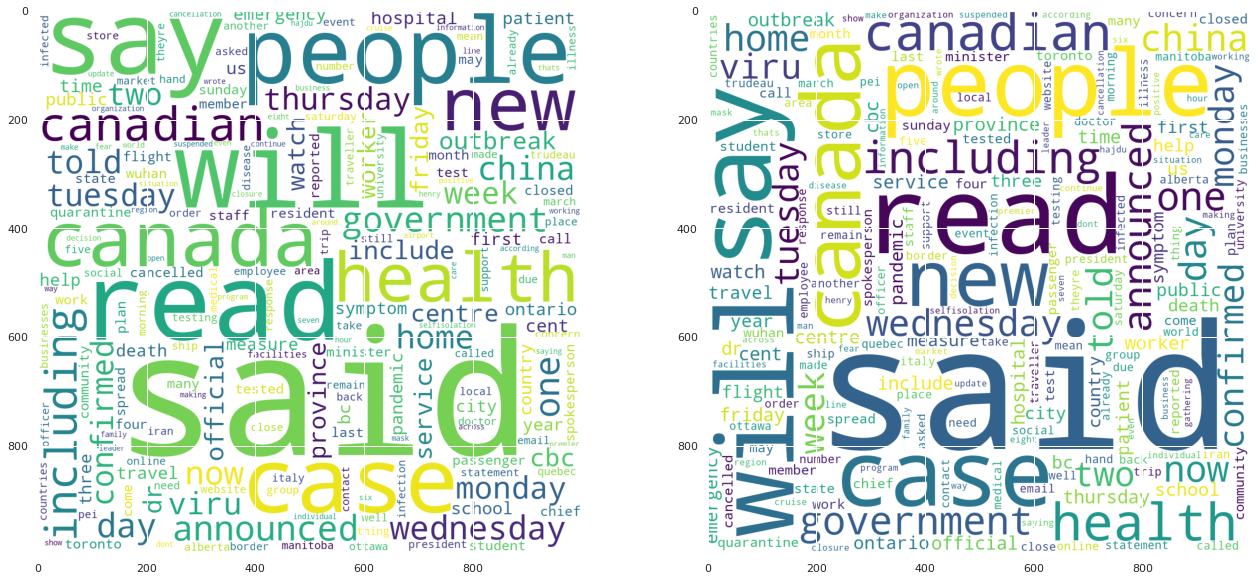

In [ ]:
plt.figure(figsize=(22,10))
plt.subplot(1,2,1)
plt.imshow(wordcloud0)
plt.subplot(1,2,2)
plt.imshow(wordcloud1)
#plt.show()

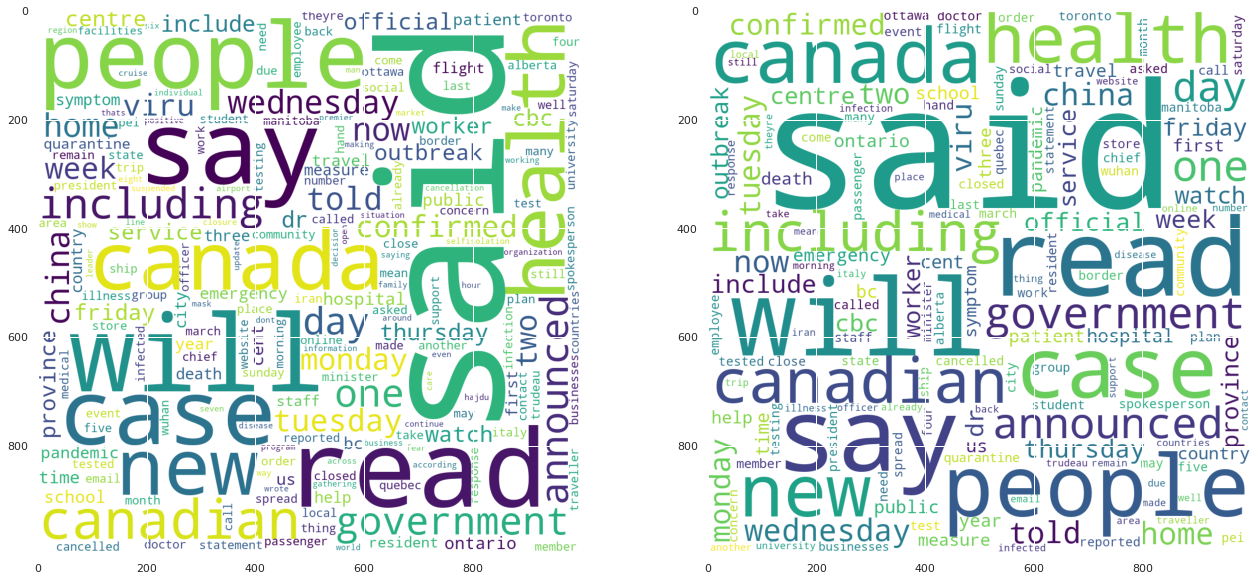

In [ ]:
plt.figure(figsize=(22,10))
plt.subplot(1,2,1)
plt.imshow(wordcloud2)
plt.subplot(1,2,2)
plt.imshow(wordcloud3)
#plt.show()

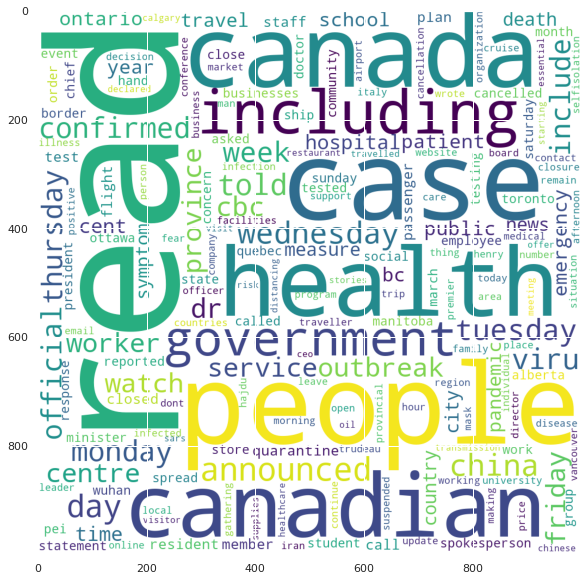

In [ ]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud4)

For cluster4, I added the stop_words to the param stopwords when constructing the word cloud. Therefore, major words such as "say, said, will" are removed and others major words could be seen.

All 5 word clouds have similar major words such as health, people, canadian. Other words could be considered are government, announced, china.

--> these articles might imply goverment's policy on the Covid-19 pandemic in Canada as CBC news is a canadian news broacasting network.